In [37]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [38]:
import sys
sys.path.append("../")
from datatools.analyzer import *
from utterance.error_tools import *

from datatools.maneger import DataManager
from datatools.preproc import Preprocessor

In [39]:
path = "../hand_labeled/"
datalist = ['DCM', 'DIT', 'IRS']
error_types = ['Unclear intention', 'Wrong information',
 'Ignore question', 'Topic transition error', 
 'Lack of information', 'Repetition', 
 'Contradiction', 'Self-contradiction',
  'Lack of common sense', 'Semantic error',
   'Grammatical error', 'Ignore proposal', 
   'Ignore offer', 'Lack of sociality', 
   'Uninterpretable', 'Ignore greeting', 
   'No-Err']


In [40]:
convs = read_conv(path, datalist)

In [41]:
sys.path.append("../response/")
from feature import Feature

In [42]:
F1_path = "../X_y_data/response/"
F1_name = "forback1.pickle"
featureM1 = DataManager(F1_path)

F_fb = featureM1.load_data(F1_name)
F_fb.set_preprocessor(Preprocessor())

success load : ../X_y_data/response/forback1.pickle
300


In [43]:
from sklearn.ensemble import AdaBoostClassifier
model1_path = "../models/response/"
model1_name = "forback_clf.pickle"
modelM1 = DataManager(model1_path)

clf_fb = modelM1.load_data(model1_name)

success load : ../models/response/forback_clf.pickle


In [44]:
# 残す形態素
pos_sets = set("名詞 代名詞 動詞 形容詞 接続詞 連体詞".split() )
def utt2vecter_s(ut):
    vector = np.zeros(300)
    remains = 0
    for token in nlp(ut.utt):
        tag = token.tag_.split("-")[0]
        if tag in pos_sets:
            vector += token.vector
            remains += 1
    
    if remains < 2:
        return vector
    else:
        return vector/remains


In [45]:
def utt2vecter_mini(ut, dim=10):
    vector = np.zeros(300)
    remains = 0
    for token in nlp(ut.utt):
        tag = token.tag_.split("-")[0]
        if tag in pos_sets:
            vector += token.vector
            remains += 1
    
    if remains < 2:
        return vector[:dim]
    else:
        return vector[:dim]/remains
    # return np.zeros(dim)

In [46]:
from pyknp import Juman
from sentence_transformers import SentenceTransformer
import scipy.spatial
model_path = "/home/yamada/Downloads/training_bert_japanese"
Nmodel = SentenceTransformer(model_path, show_progress_bar=False)
emb_dim = Nmodel.encode(["お辞儀をしている男性会社員"])[0].shape[0]

In [47]:
emb_dim

768

In [48]:
def utt2vecter_BERT(ut):
    return Nmodel.encode(ut.utt)[0]

In [49]:
length = 4

In [50]:
from tqdm import tqdm
def make_Xy_conv(convs, length, errors:list,  dim=300):
    X = []
    y = []
    for conv in tqdm(convs):
        # X_ = [ np.zeros(2*dim+2) for _ in range(length-1) ] 
        X_ = [ np.zeros(dim+2) for _ in range(length-1) ] 
        prev_vector = np.zeros( dim )
        for i, ut in enumerate(conv):

            # fb
            # 0: 後ろ向き   1: 前向き
            f = F_fb.featurization(ut.utt)
            fb_proba = clf_fb.predict_proba(f.reshape(1, -1))[0]
            # vector = utt2vecter_mini(ut, dim)
            if dim==768:
                vector = utt2vecter_BERT(ut)
            else:
                vector = utt2vecter_s(ut)

            # x_cat_vector = np.concatenate( [fb_proba, prev_vector-vector, vector] )
            x_cat_vector = np.concatenate( [fb_proba, prev_vector-vector] )
            prev_vector = vector
            X_.append( x_cat_vector )
            if not ut.is_system() or ut.is_utt_level_error():
                continue
            X.append(X_[-length:])
            
            y.append(1 if ut.is_error_included(errors) else 0)
        # break
    return np.array(X), np.array(y)



In [51]:
def make_Xy_conv2(convs, length, errors:list,  dim=300):
    X = []
    y = []
    for conv in tqdm(convs):
        # X_ = [ np.zeros(2*dim+2) for _ in range(length-1) ] 
        X_ = [ np.zeros(dim+2) for _ in range(length-1) ] 
        prev_vector = np.zeros( dim )
        for i, ut in enumerate(conv):
            if not ut.is_system() or ut.is_utt_level_error():
                continue
            # fb
            # 0: 後ろ向き   1: 前向き
            f = F_fb.featurization(ut.utt)
            fb_proba = clf_fb.predict_proba(f.reshape(1, -1))[0]
            # vector = utt2vecter_mini(ut, dim)
            if dim==768:
                vector = utt2vecter_BERT(ut)
            else:
                vector = utt2vecter_s(ut)

            # x_cat_vector = np.concatenate( [fb_proba, prev_vector-vector, vector] )
            x_cat_vector = np.concatenate( [fb_proba, prev_vector-vector] )
            prev_vector = vector
            X_.append( x_cat_vector )

            if not ut.is_system() or ut.is_utt_level_error():
                continue
            X.append(X_[-length:])
            
            y.append(1 if ut.is_error_included(errors) else 0)
        # break
    return np.array(X), np.array(y)

In [52]:
errors = ["Topic transition error", "Unclear intention", "Lack of information"]
# errors = errorprint(errors)
emb_dim = 768
X, _ = make_Xy_conv(convs, length, errors, dim=emb_dim)

100%|██████████| 200/200 [20:29<00:00,  6.15s/it]


In [216]:
y = []
errors = ["Topic transition error", "Unclear intention", "Lack of information"]
errors = errors[:1]
for conv in tqdm(convs):
    for i, ut in enumerate(conv):
        if not ut.is_system() or ut.is_utt_level_error():
                continue
        y.append(1 if ut.is_error_included(errors) else 0)

100%|██████████| 200/200 [00:00<00:00, 78670.24it/s]


In [199]:
data_path = "../X_y_data/context/"
data_name = "topic_proposal_bert1.pickle"
dataM = DataManager(data_path)

if dataM.is_exist(data_name):
    DATA_Xy = dataM.load_data(data_name)
    X = DATA_Xy[0]
    y = DATA_Xy[1]
else:
    dataM.save_data(data_name, [X, y])

success load : ../X_y_data/context/topic_proposal_bert1.pickle


In [200]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim

In [232]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size, batch_size):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。    
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        # LSTMの隠れ層。これ１つでOK。超便利。
        self.lstm = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True, bidirectional=True )
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        # self.softmax = 
    
    def forward(self, x):
        #embeds.size() = (batch_size × len(sentence) × embedding_dim)
        batch_size, seq_len = x.shape[0], x.shape[1]
        # _, hidden_layer = self.lstm(x[:, :, 2:])
        _, hidden_layer = self.lstm(x)
        # print(hidden_layer)
        bilstm_out = torch.cat([hidden_layer[0][0], hidden_layer[0][1]], dim=1)
        # y = self.hidden2tag(hidden_layer[0].view(batch_size, -1))

        y = self.hidden2tag(bilstm_out)
        y = F.log_softmax(y, dim=1)
        return y

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

In [234]:
# split = int(len(X)*0.8)
# X_train, X_test = X[:split], X[split:]
# y_train, y_test = y[:split], y[split:]
# print(len(X), len(X_test))
np.count_nonzero(y_train)

155

In [235]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [236]:
X_train = X_train[:-1]
y_train = y_train[:-1]
leng = len(y_train)
print(leng)
for i, v in enumerate(y_train):
    if leng %(i+1) == 0:
        print(i+1, end=", ")

1450
1, 2, 5, 10, 25, 29, 50, 58, 145, 290, 725, 1450, 

In [237]:
BATCH_SIZE = 145
epoch_ = 400
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [238]:
EMBEDDING_DIM = emb_dim+2
HIDDEN_DIM = emb_dim//2

# EMBEDDING_DIM = 2*emb_dim+2
# HIDDEN_DIM = emb_dim

OUTPUT_DIM = 2
X.shape

(1814, 4, 770)

In [239]:
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BATCH_SIZE)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [240]:
losses = []
loss_border = 0.0001
# print("error[{0}]".format(error_types[error_i]))
for epoch in range(epoch_):  # again, normally you would NOT do 300 epochs, it is toy data
    all_loss = 0
    for data in trainloader:
        X_t_tensor = torch.tensor(data[0], device='cuda:0').float()
        # y_t_tensor = torch.tensor(data[1].reshape(batch_size, 1), device='cuda:0').float()
        y_t_tensor = torch.tensor(data[1], device='cuda:0').long()
        optimizer.zero_grad()
        model.zero_grad()
        # print(X_t_tensor.shape)

        score = model(X_t_tensor)
        loss_ = loss_function(score, y_t_tensor)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score
        del loss_
    losses.append(all_loss)
    if (epoch+1) % 50 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
    # if all_loss <= loss_border:
    #     print("loss was under border(={0}) : train end".format(loss_border))
    #     break
print("done")

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


epoch 50 	 loss 0.1391377728432417
epoch 100 	 loss 0.01408341689966619
epoch 150 	 loss 0.0046214310568757355
epoch 200 	 loss 0.0021462365984916687
epoch 250 	 loss 0.0011725914737326093
epoch 300 	 loss 0.0007029699554550461
epoch 350 	 loss 0.0004470148924156092
epoch 400 	 loss 0.00029588289908133447
done


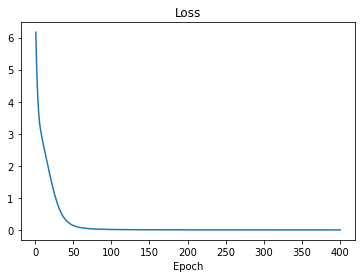

In [241]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [242]:
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device='cuda:0').float()
    y_tensor = torch.tensor(y_test, dtype=torch.long, device='cuda:0')
            # 推論
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

In [243]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred))

confusion matrix = 
 [[317   9]
 [ 34   3]]
accuracy =  0.8815426997245179
precision =  0.25
recall =  0.08108108108108109
f1 score =  0.12244897959183675


In [244]:
from tqdm import tqdm
def make_X_str(convs, length):
    X_str = []
    y = []
    for conv in tqdm(convs):
        X_ = []
        for i, ut in enumerate(conv):
            X_.append( ut.utt )
            if not ut.is_system() or ut.is_utt_level_error():
                continue
            X_str.append(X_[-length:])
        # break
    return X_str

In [245]:
X_str = make_X_str(convs, length)

100%|██████████| 200/200 [00:00<00:00, 122069.38it/s]


In [246]:
# for i in range(len(y_test)):

#         # 本来エラーではないけどエラー扱い
#         # if y_test[j]==0 and y_pred[j]==1:
#         #     print("本来エラーではないけどエラー扱い", ut.did)
#         #     print(conv_list[-length:])
#         #     print()
#         # if y_test[j]==1 and y_pred[j]==0:
#         #     print("本来エラーなのに非エラー扱い", ut.did)
#         #     print(conv_list)
#         #     print()
#     j = i+split
#     if y_test[i]==1 and y_pred[i]==1:
#         print("よく検出した！えらいぞ", ut.did)
#         print(X_str[j])
#         print()
#     pass
        
        